# Toy example

In [269]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import networkx as nx
from itertools import combinations
import seaborn as sns
from scipy.special import expit
import pandas as pd
np.random.seed(42)

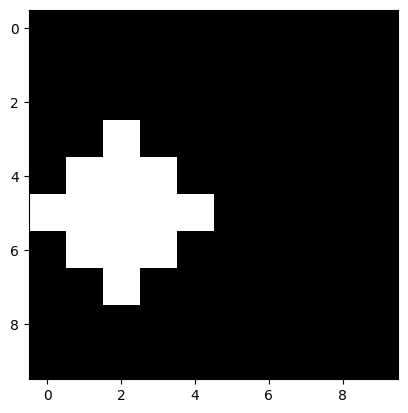

In [102]:
def generate_image(r, x, y, size=10):
    img = np.zeros((size, size), dtype=np.uint8)
    c = (int(x), int(y))
    cv2.circle(img, c, int(r), 255, -1)
    return img

plt.imshow(generate_image(2, 2, 5, size=10),cmap='gray')
plt.show()

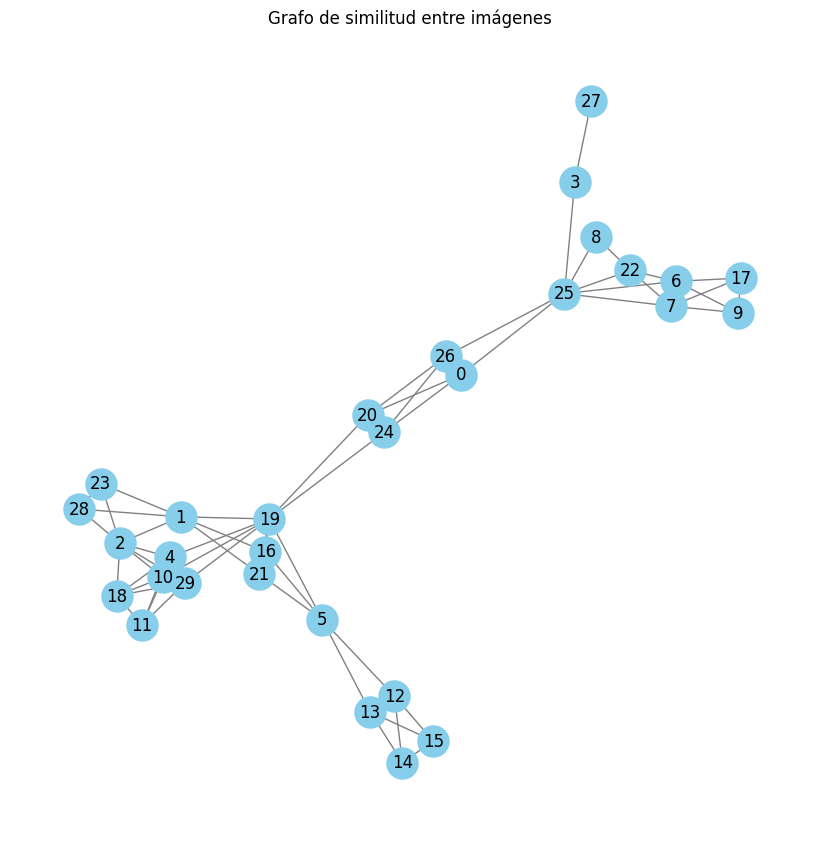

In [296]:
def generate_dataset(n_img=30, size=10):
    images = []
    params = []
    for _ in range(n_img):
        r = 2
        x = np.random.uniform(r, size - r)
        y = np.random.uniform(r, size - r)
        img = generate_image(r, x, y, size)
        images.append(img)
        params.append((r, x, y))
    return images, params


number_images = 30
images, parameters = generate_dataset(n_img=number_images)

def mse(img1, img2):
    return np.mean((img1.astype("float") - img2.astype("float")) ** 2)/255.0**2

X = np.zeros((len(images), len(images)))
for i, j in combinations(range(len(images)), 2):
    X[i, j] = mse(images[i], images[j])
    X[j, i] = X[i, j]


def build_g(imagenes, umbral):
    G = nx.Graph()
    for idx, _ in enumerate(imagenes):
        G.add_node(idx)
    for i, j in combinations(range(len(imagenes)), 2):
        distancia = mse(imagenes[i], imagenes[j])
        if distancia < umbral:
            G.add_edge(i, j)
    return G
def visualize_g(G):
    pos = nx.spring_layout(G, seed=42)
    plt.figure(figsize=(8, 8))
    nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=500, edge_color='gray')
    plt.title("Grafo de similitud entre imágenes")
    plt.show()

G = build_g(images, umbral=np.percentile(X.reshape(-1), 25))
Y = nx.to_numpy_array(G, dtype=int)
X = (X - np.mean(X.reshape(-1)))/np.var(X.reshape(-1))**0.5
visualize_g(G)

MSE = 0.10


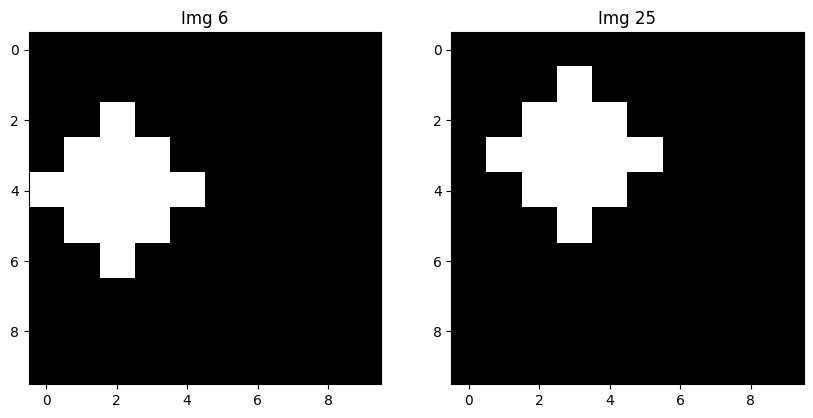

In [298]:
a , b = np.array(G.edges())[np.random.randint(0, len(G.edges()))]
print(f"MSE = {mse(images[a], images[b]):.2f}")
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(images[a], cmap='gray')
plt.title(f"Img {a}")
plt.subplot(1, 2, 2)
plt.imshow(images[b], cmap='gray')
plt.title(f"Img {b}")
plt.show()


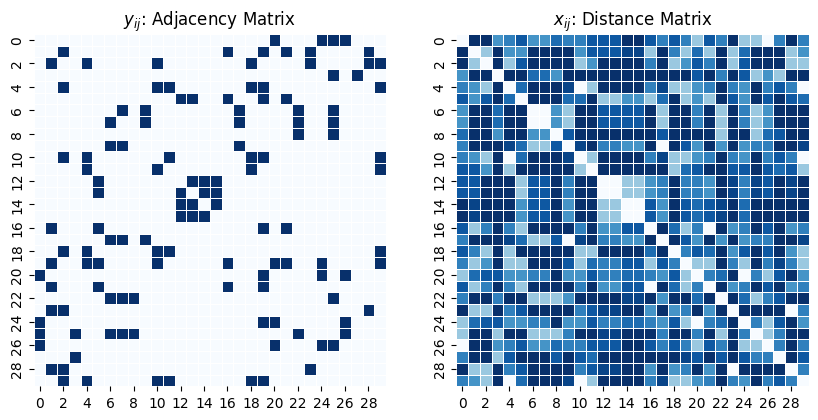

In [299]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.heatmap(Y, annot=False, cmap="Blues", cbar=False, square=True, linewidths=0.5, linecolor='white')
plt.title(r"$y_{ij}$: Adjacency Matrix")
plt.subplot(1, 2, 2)
sns.heatmap(X, annot=False, cmap="Blues", cbar=False, square=True, linewidths=0.5, linecolor='white')
plt.title(r"$x_{ij}$: Distance Matrix")

plt.show()

# Latent space

To start the latent space model, the number of nodes $n$ in the graph is calculated and the latent variables are randomly initialized with sampling from a normal standard distribution a matrix of size $n\times 2$ since we are representing our network in a $2$-dimensional space.

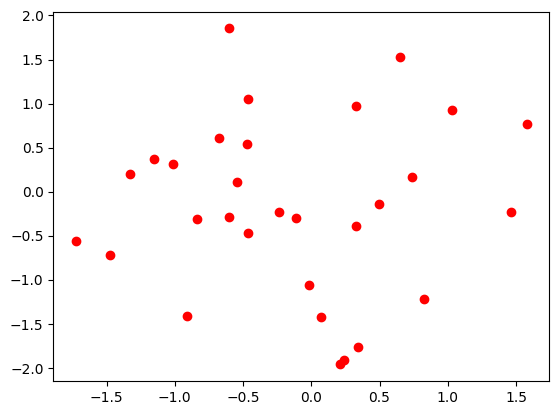

In [271]:
n = len(G.nodes)

Z = np.random.randn(n, 2)
plt.plot(Z[:,0],Z[:,1], 'ro')
plt.show()

In [274]:
def loglikelihood(Z,alpha,beta):
    total = 0.0
    for i in G.nodes():
        for j in G.nodes():
            if i != j:
                d = 0.5 * np.linalg.norm(Z[i] - Z[j])**2
                eta = alpha + beta * X[i, j] - d
                total += eta * Y[i,j]  + np.log(expit(-eta))
    return total

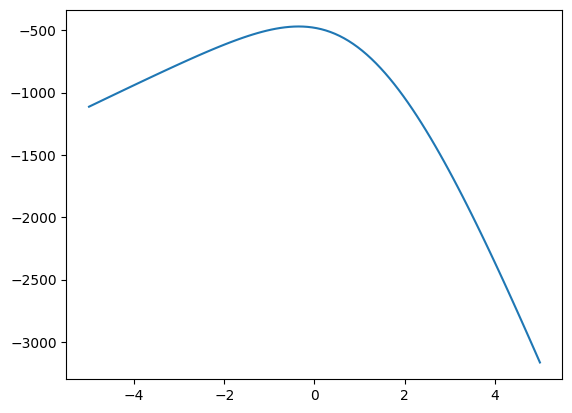

In [275]:
plt.plot(np.linspace(-5,5,100),[loglikelihood(Z,t,t) for t in np.linspace(-5,5,100)])
plt.show()

In [279]:
def grad_loglikelihood(Z,alpha,beta):
    grad_Z = np.zeros_like(Z)
    grad_alpha = 0.0
    grad_beta = 0.0
    for i in G.nodes():
        for j in G.nodes():
            if j != i:
                d = 0.5 * np.linalg.norm(Z[i] - Z[j])**2
                eta = alpha + beta * X[i, j] - d
                grad_Z[i,:] +=  (Z[j] - Z[i]) * (Y[i,j] - expit(eta))
                grad_alpha +=  (Y[i,j] - expit(eta))
                grad_beta +=  X[i,j] * (Y[i,j] - expit(eta))
    return grad_Z, grad_alpha, grad_beta

-486.4106082626041
-469.262435455006


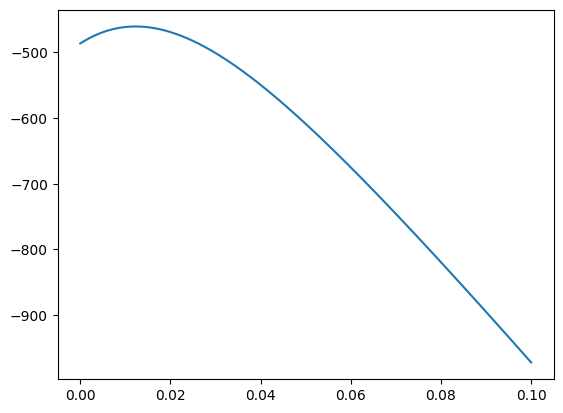

In [281]:
grad_Z,  grad_a, grad_b = grad_loglikelihood(Z,0.1,0.1)
lr = 0.005
print(loglikelihood(Z,0.1,0.1))
print(loglikelihood(Z +lr*grad_Z,0.1+lr*grad_a, 0.1+lr*grad_b))
plt.plot(np.linspace(0.0,0.1,1000),[loglikelihood(Z +lr*grad_Z,0.1+lr*grad_a,0.1+lr*grad_b) for lr in np.linspace(0.0,0.1,1000)])
plt.show()

## Searching MLE

For searching the maximum likelihood estimation, we search the maximum of the loglikelihood function through gradient descent with line search.

In [ ]:
def SearchingMLE(Z_init, a_init, b_init, tol=1e-1, max_iter=1000, alpha_init=0.1, rho=0.5, c=1e-4):
    Z0 = Z_init
    historyZ = [Z0]

    a0 = a_init
    historya = [a0]

    b0 = b_init
    historya = [b0]
    
    for i in range(max_iter):
        grad_Z,  grad_a, grad_b = grad_loglikelihood(Z0,a0,b0)
        if np.linalg.norm(grad_Z) + np.abs(grad_a) < tol:
            break  # Convergence criterion
        
        alpha = alpha_init
        
        # Line search using the Armijo condition
        while loglikelihood(Z0 + alpha * grad_Z,a0 + alpha*grad_a) < loglikelihood(Z0,a0)+ c * alpha * (np.trace(np.transpose(grad_Z) @ Z0) + grad_a * a0):
            alpha *= rho
            if alpha < 1e-4:
                alpha = 0.0
                break
        
        # Update step
        Z0 = Z0 + alpha * grad_Z  
        a0 = a0 + alpha * grad_a
        
        historyZ.append(Z0)
        historya.append(a0)
    
    return  Z0, a0, historyZ, historya

In [ ]:
Z0, a0, historyZ, historya  =  SearchingMLE(np.random.randn(n, 2),np.random.randn())
Z0 = Z0 - np.mean(Z0, axis=0)
plt.plot([loglikelihood(historyZ[t],historya[t]) for t in range(len(historya))])
plt.show()